# Camelyon_16_extract_patch_extract_features

#### Import modules

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
from torch.nn.utils.rnn import pack_sequence
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import cv2 
import openslide
from openslide import OpenSlide
from openslide import open_slide
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage.color import rgb2hsv
import numpy as np
import tqdm
import os
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

/pasteur/appa/homes/cbacquie/miniconda3/envs/camelyon/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


#### Create_mask_Segmentation

In [3]:
def get_mask1(thumbnail,path_mask1):
    """conversion of the image in hsv format, mask on the saturation channel with an otsu filter
    thumbnail: thumbnail created with get.thumbnail function
    path_mask1:path in which we want to save our mask
    return:save the mask as jpg in the given folder and return the mask """
    hsv = cv2.cvtColor(thumbnail, cv2.COLOR_BGR2HSV)
    plt.imshow(hsv[:,:,1])
    ret,thresh1 = cv2.threshold(hsv[:,:,1],0,255,cv2.THRESH_OTSU)
    images = [hsv, thresh1]
    titles=["Image","Treshold"]
    plt.figure(figsize=(10,10))
    for i in range(2):
        plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.figure(figsize=(10,10))
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    fg_mask1=closing
    #Image.fromarray(closing).save(path_mask1)
    return fg_mask1

In [4]:
def get_final_mask(thumbnail,fg_mask1,path_final_mask):
    """superposition of the first mask and our image in order to remove the black elements then otsu filter
    thumbnail: thumbnail created with get.thumbnail function,the same as the one used for the first mask
    path_final_mask:path in which we want to save our mask
    return:save the mask as jpg in the given folder and return the mask """
    thumbnail2 = thumbnail*np.expand_dims(fg_mask1.astype(np.float32)/255,axis=2).astype(np.uint8)
    gray = cv2.cvtColor(thumbnail2, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0).astype(np.uint8)
    # Image.fromarray(blur).save("Data/001/patch/blur.jpg")
    ret,thresh1 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    fg_mask=closing
    #Image.fromarray(fg_mask).save(path_final_mask)
    fg_mask=closing/255
    return fg_mask

#### Extract patches

In [5]:
def _edge_case(image_shape, y, x, patch_size, step_size):
    """Keep the tile size at TILE_HEIGHT, TILE_WIDTH """
    vertical_limit = image_shape[0]-patch_size
    horizontal_limit = image_shape[1]-patch_size
    new_y = max(0, min(y, vertical_limit))
    new_x = max(0, min(x, horizontal_limit))
    return new_y,new_x


In [6]:
def basic_patchify_mask(patch_size, overlap, mask, on_mask=0.01):
    """A simple patches division in grid"""
    patch_dict={}
    step_size = int(patch_size-overlap)                                    
    index = 0
    for y in range(0,mask.shape[0], step_size):                                      
        for x in range(0,mask.shape[1], step_size):
            # Moves back tile if necessary so they are all of the same size                           
            y, x = _edge_case(mask.shape, y, x, patch_size, step_size)
            # Fraction of masked pixels
            if np.mean(mask[y:y+patch_size, x:x+patch_size]) >= on_mask:
                corner = [x, y] 
                patch = {"corner": corner}
                patch_dict[index] = patch
                index += 1
    return patch_dict

In [7]:
def patchify_mask(patch_size, overlap, mask, scale=1., on_mask=0.01):
    """
    Adapt patches parameters to the mask scale and patchify.
    For best performance, scale, patch_size and overlap should be powers of 2
    Scale: original_image_size/mask_size
    """
    scaled_patch_size = int(patch_size//scale)
    scaled_overlap = int(overlap//scale)
    patch_dict = basic_patchify_mask(scaled_patch_size, scaled_overlap, mask, on_mask=on_mask)
    # Rescale
    rescaled_patch_dict = {}
    for index, patch in patch_dict.items():
        corner = patch.get("corner")
        rescaled_corner = [int(corner[0]*scale), int(corner[1]*scale)]
        rescaled_patch_dict[index] = {"corner": rescaled_corner, "size": patch_size}
    return rescaled_patch_dict


In [8]:
def pixels_extraction_numpy(image, patch):
    """Get the pixel information for a patch"""
    corner = patch.get("corner")
    patch_size = patch.get("size")
    # Numpy uses [y, x, c] axis notation, corner is [x, y] 
    corner.reverse()
    pixels = image[
            corner[0]:corner[0]+patch_size,
            corner[1]:corner[1]+patch_size,
            ...
            ]
    return pixels

def pixels_extraction_openslide(image, patch, level=0):
    """Get the pixel information for every patch"""
    corner = patch.get("corner")
    patch_size = patch.get("size")
    pixels = image.read_region(location=corner, level=level, size=(patch_size, patch_size))
    return pixels


In [9]:
def visualize_patches(image, patch_dict,display_path, line_width=20, scale=1.):
    from random import randint
    import cv2
    display_image = np.asarray(image)
    for index, patch in patch_dict.items():
        color = [randint(0,255) for _ in range(3)]
        scaled_patch_corner = [int(coord//scale) for coord in patch["corner"]]
        scaled_patch_size = int(patch["size"]//scale)
        bottom_right_corner = [coord+scaled_patch_size for coord in scaled_patch_corner]
        # Draw the rescaled patch rectangles
        cv2.rectangle(display_image, scaled_patch_corner, bottom_right_corner, color, line_width)
        #Image.fromarray(display_image).save(display_path)
    return display_image

In [10]:
def save_patches(image,patch_dict, directory,basename,level):
    """Save all images in the patch dictionary
    save all images in the directory in .png"""
    L=[]
    i=0
    for index, patch in tqdm.tqdm(patch_dict.items()):
        L.append([i,patch_dict[index]])
        i+=1
        pixels = pixels_extraction_openslide(image, patch, level=level)
        pixels = pixels.convert('RGB')
        pixels=pixels.resize((224,224),resample=Image.BILINEAR)
        pixels.save((os.path.join(directory, basename+str(index)+'.png')))
    return L
        
        

In [11]:
def see_patch(directory, basename):
    """show 225 first patches"""
    fig=plt.figure(figsize=(30,30)) 
    rows = 15
    columns = 15
    for i in range(1,226):
        image = mpimg.imread(os.path.join(directory, basename+str(i)+'.png'))
        # print(image.min(),image.max())
        a=fig.add_subplot(rows, columns, i) 
        a.imshow(image) 
        plt.axis('off') 
        plt.title(str(i))

ok_mask1
ok_final_mask
ok_patch_dict


100%|█████████████████████████████████████████████████████████████████████████████| 29364/29364 [21:29<00:00, 22.77it/s]


ok_save
None


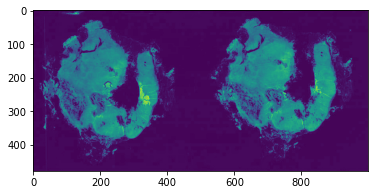

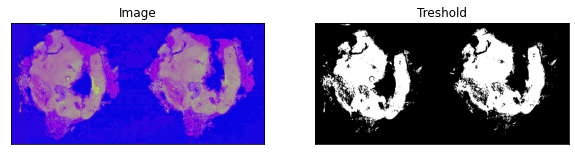

<Figure size 720x720 with 0 Axes>

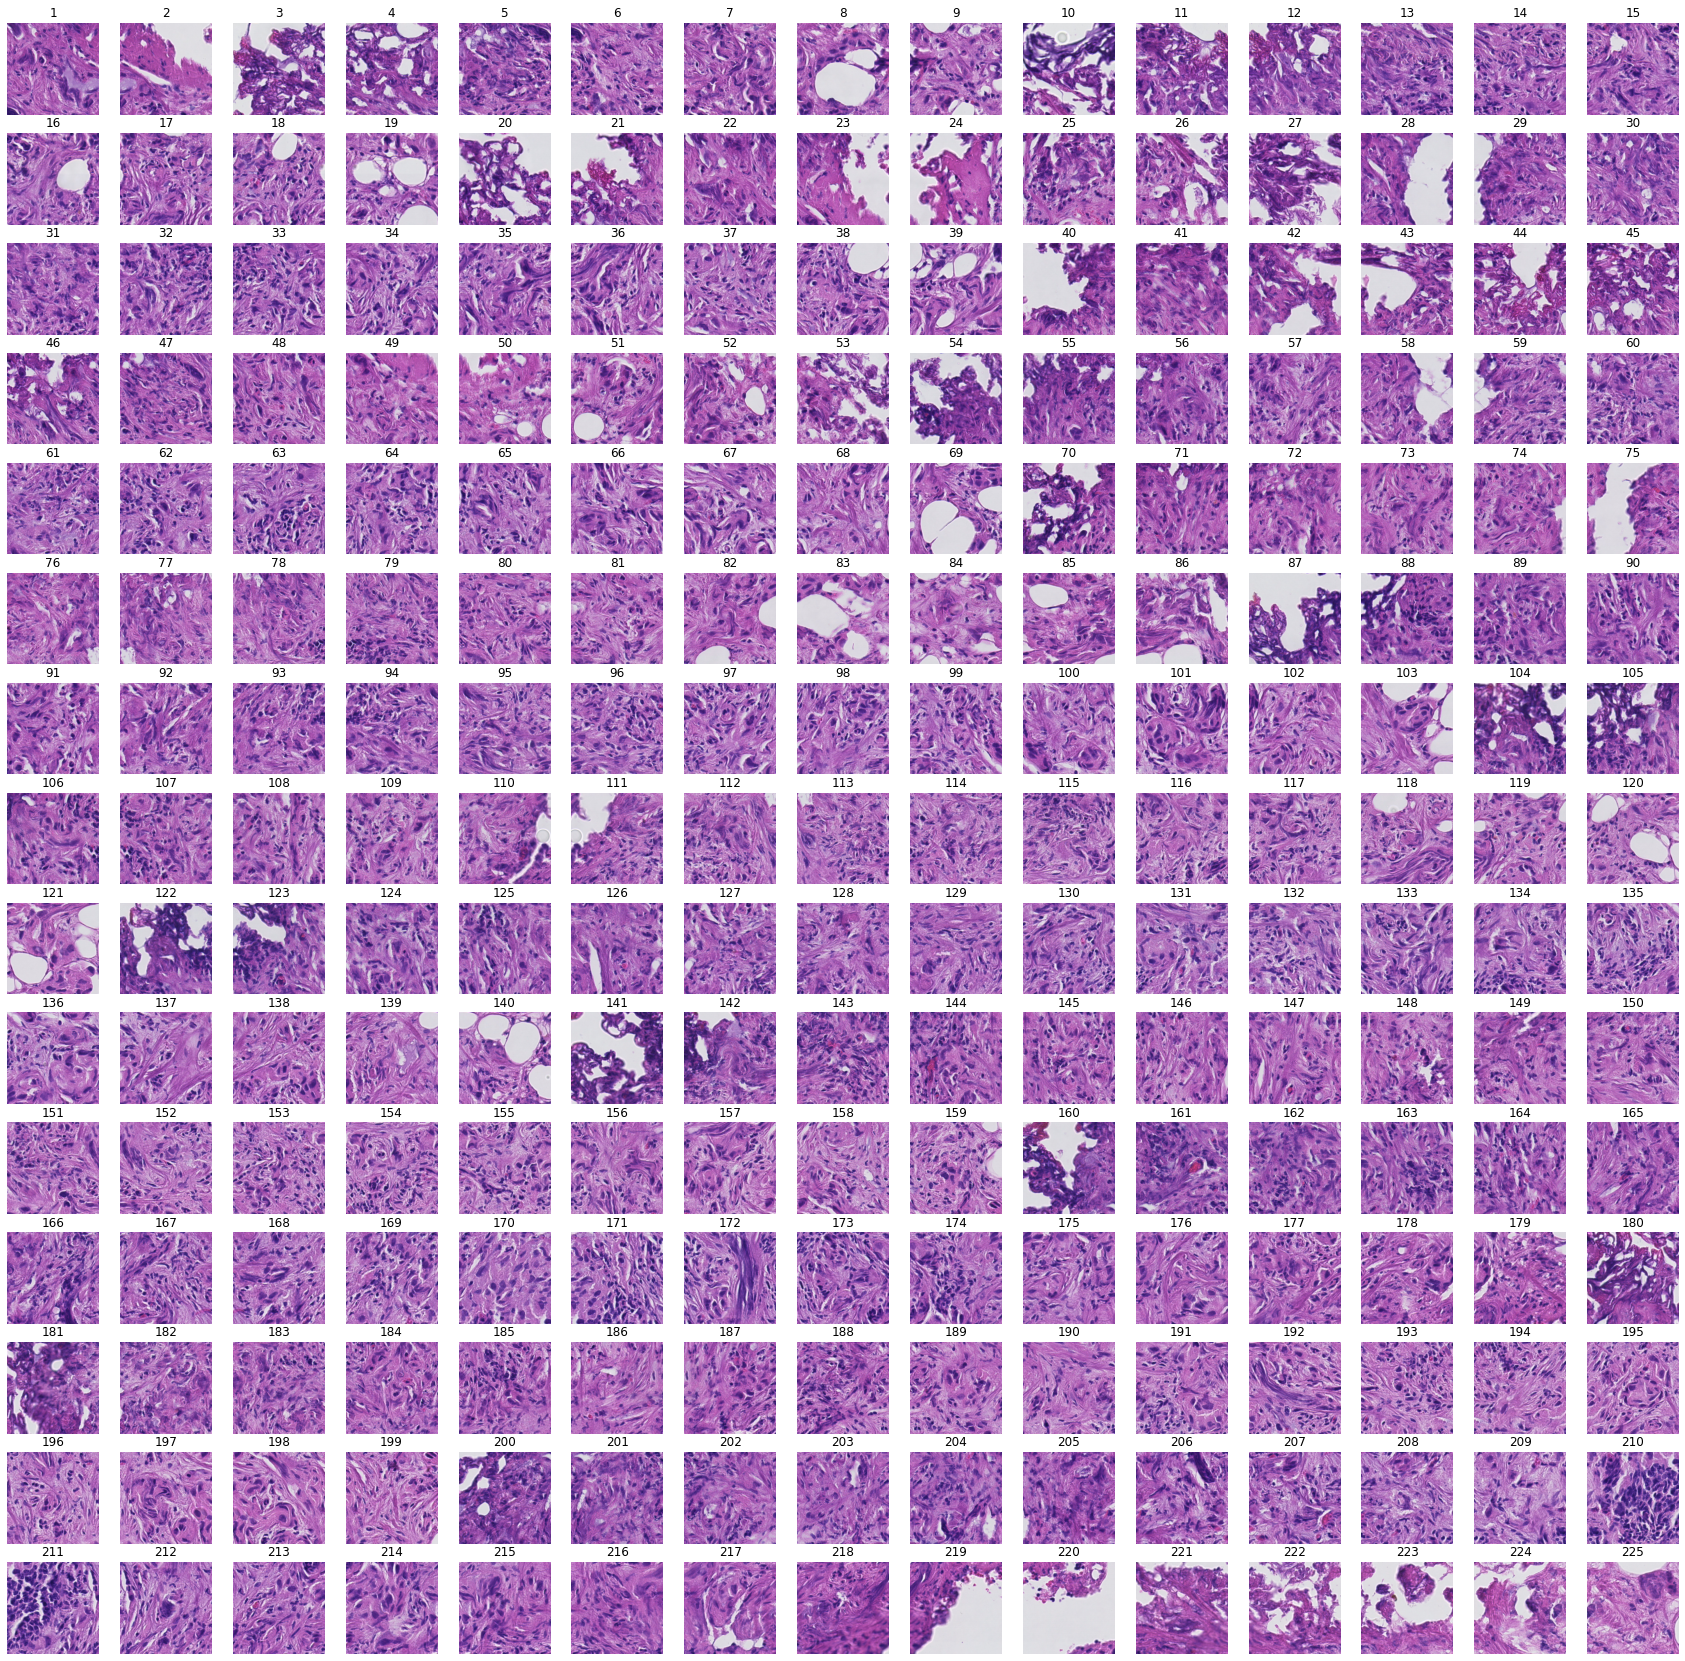

In [53]:
def main(i):
    ####Parameters####
    patch_size=500 #Take 500x500 patches, then will be resize to 224x224
    tb_size=1000
    overlap=0
    level=0
    ####images####
    image_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/tumor_{i:03}.tif"
    img=OpenSlide(image_path)
    directory_patch=f"zeus/Data/Camelyon/tumor/images/{i:03}/patch"
    path_mask1=f"zeus/Data/Camelyon/tumor/images/{i:03}/mask/mask1.jpg"
    path_final_mask=f"zeus/Data/Camelyon/tumor/images/{i:03}/mask/final_mask.jpg"
    basename=f"tumor_{i:03}_patch"
    thumbnail=img.get_thumbnail((1000,1000))
    thumbnail.show()
    display_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/patch/display_patches.jpg"
    thumbnail=np.array(thumbnail)
    #print(thumbnail.min(),thumbnail.max())
    thumbnail= thumbnail.astype(np.uint8)
    ####Parameters####
    im_width, im_height = img.dimensions
    process_scale = max(im_width,im_height)/1000
    scale = img.level_downsamples[level]
    ####Get mask1####
    fg_mask1=get_mask1(thumbnail,path_mask1)
    print("ok_mask1")
    ####Get final mask####
    fg_mask=get_final_mask(thumbnail,fg_mask1,path_final_mask)
    print("ok_final_mask")
    ####Get patches####
    patch_dict = patchify_mask(int(patch_size*scale),
        overlap=overlap, mask=fg_mask, scale=process_scale)
    for patch in patch_dict.values():
        patch["size"] = int(patch["size"]//scale)
    print("ok_patch_dict")
    ####Visualize patch on the image####
    visualize_patches(thumbnail, patch_dict,display_path, scale=process_scale, line_width=5)
    #print("ok_display")
    ####Extract pixels and save####
    L=save_patches(img, patch_dict,directory_patch,basename,level=level)
    np.save(f"zeus/Data/Camelyon/tumor/images/{i:03}/patch_dict.npy",L) #keep the coordinates of the patches 
    print("ok_save")
    ####Visualize patch####
    print(see_patch(directory_patch,basename))
if __name__=="__main__":
    main(102)  #to extract patches of the image i main(i)

##### Create Dataset

In [3]:
data_transforms = {"tumor" : transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "normal":  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
data_dir="zeus/Data/Camelyon/"
image_datasets={}
dataset_sizes = {}
for x in tqdm.tqdm([f"tumor/images/{i:03}/" for i in range(1,111)]):
    image_datasets[x]=datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms["tumor"])
    dataset_sizes[x] = len(image_datasets[x])

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [02:39<00:00,  1.45s/it]


In [5]:
for x in tqdm.tqdm([f"normal/images/{i:03}/" for i in range(1,111)]):
    image_datasets[x]=datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms["normal"])
    dataset_sizes[x] = len(image_datasets[x])
#for x in [f"test/{i:03}/patch" for i in range(1,21)]:
 #   image_datasets[x]=datasets.ImageFolder(os.path.join(data_dir, x),
  #                                        data_transforms["test"])
   # dataset_sizes[x] = len(image_datasets[x])

100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [02:02<00:00,  1.11s/it]


In [ ]:
for x in tqdm.tqdm([f"normal/images/{i:03}/" for i in range(1,111)]):
    for i in range(len(image_datasets[x].targets)):
        image_datasets[x].targets[i]=0 #normal=0

In [ ]:
for x in tqdm.tqdm([f"tumor/images/{i:03}/" for i in range(1,111)]):
    for i in range(len(image_datasets[x].targets)):
        image_datasets[x].targets[i]=1 #tumor=1

#### Create Dataloaders

In [ ]:
dataloaders ={}
for x in tqdm.tqdm([f"normal/images/{i:03}/" for i in range(1,111)]):
    dataloaders[x]=torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=16)
#for x in [f"test/{i:03}/patch" for i in range(1,21)]:
 #   dataloaders[x]=torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
  #                                           shuffle=False, num_workers=4)
    

In [15]:
for x in tqdm.tqdm([f"tumor/images/{i:03}/" for i in range(1,111)]):
    dataloaders[x]=torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=16)

  0%|                                                                                            | 0/50 [00:00<?, ?it/s]/pasteur/appa/homes/cbacquie/miniconda3/envs/camelyon/lib/python3.7/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4195.14it/s]


#### Extract Features

In [61]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Identity(num_ftrs, 2)
model_conv = model_conv.to(device)

/pasteur/appa/homes/cbacquie/miniconda3/envs/camelyon/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/pasteur/appa/homes/cbacquie/miniconda3/envs/camelyon/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
def visualize_model(model,dataloader):
    L_features=[]
    model.eval()
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            L_features.append(outputs)
    return L_features

In [63]:
L_features_normal=[]

for x in tqdm.tqdm([f"normal/images/{i:03}/" for i in range(1,111)]):
    L_features_normal.append(visualize_model(model_conv,dataloaders[x]))


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [33:03<00:00, 39.67s/it]


In [64]:
L_features_tumor=[]
for x in tqdm.tqdm([f"tumor/images/{i:03}/" for i in range(1,111)]):
    L_features_tumor.append(visualize_model(model_conv,dataloaders[x]))
    

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [36:32<00:00, 43.85s/it]


In [66]:
u=0
for i in tqdm.tqdm(range(0,110)):
    features_tumor=torch.vstack(L_features_tumor[u])
    features_tumor.shape
    torch.save(features_tumor,f"zeus/Data/Camelyon/tumor/features/{i+1:03}/feat_tumor_{i+1:03}.npy")
    u+=1

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.81it/s]


In [69]:
u=0
for i in tqdm.tqdm(range(0,110)):
    features_normal=torch.vstack(L_features_normal[u])
    features_normal.shape
    torch.save(features_normal,f"zeus/Data/Camelyon/normal/features/{i+1:03}/feat_normal_{i+1:03}.npy")
    u+=1

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


In [70]:
#verification qu'on a bien des tensors de taille nx2048 
L=[]
for i in tqdm.tqdm(range(0,110)):
    a=torch.load(f"zeus/Data/Camelyon/normal/features/{i+1:03}/feat_normal_{i+1:03}.npy")
    L.append(a.shape)
print(L)
#ok

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]

[torch.Size([10210, 2048]), torch.Size([2630, 2048]), torch.Size([6263, 2048]), torch.Size([6881, 2048]), torch.Size([5339, 2048]), torch.Size([21074, 2048]), torch.Size([6817, 2048]), torch.Size([6757, 2048]), torch.Size([8175, 2048]), torch.Size([17778, 2048]), torch.Size([6103, 2048]), torch.Size([5193, 2048]), torch.Size([6940, 2048]), torch.Size([12783, 2048]), torch.Size([8347, 2048]), torch.Size([25506, 2048]), torch.Size([4105, 2048]), torch.Size([6164, 2048]), torch.Size([7972, 2048]), torch.Size([12228, 2048]), torch.Size([5285, 2048]), torch.Size([6605, 2048]), torch.Size([2307, 2048]), torch.Size([1138, 2048]), torch.Size([4333, 2048]), torch.Size([12670, 2048]), torch.Size([11068, 2048]), torch.Size([12458, 2048]), torch.Size([19792, 2048]), torch.Size([10260, 2048]), torch.Size([25019, 2048]), torch.Size([3454, 2048]), torch.Size([6545, 2048]), torch.Size([3069, 2048]), torch.Size([11296, 2048]), torch.Size([4934, 2048]), torch.Size([14374, 2048]), torch.Size([3525, 2048]

In [71]:
#verification qu'on a bien des tensors de taille nx2048 
L=[]
for i in tqdm.tqdm(range(0,110)):
    a=torch.load(f"zeus/Data/Camelyon/tumor/features/{i+1:03}/feat_tumor_{i+1:03}.npy")
    L.append(a.shape) 
print(L)
#ok

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]

[torch.Size([11642, 2048]), torch.Size([9514, 2048]), torch.Size([13087, 2048]), torch.Size([4326, 2048]), torch.Size([3378, 2048]), torch.Size([6548, 2048]), torch.Size([4992, 2048]), torch.Size([11116, 2048]), torch.Size([5277, 2048]), torch.Size([4886, 2048]), torch.Size([15609, 2048]), torch.Size([14273, 2048]), torch.Size([6480, 2048]), torch.Size([4416, 2048]), torch.Size([3133, 2048]), torch.Size([14977, 2048]), torch.Size([10544, 2048]), torch.Size([13517, 2048]), torch.Size([8385, 2048]), torch.Size([4046, 2048]), torch.Size([6079, 2048]), torch.Size([2229, 2048]), torch.Size([8868, 2048]), torch.Size([5139, 2048]), torch.Size([5306, 2048]), torch.Size([9143, 2048]), torch.Size([7194, 2048]), torch.Size([14552, 2048]), torch.Size([22092, 2048]), torch.Size([5091, 2048]), torch.Size([3051, 2048]), torch.Size([34072, 2048]), torch.Size([6211, 2048]), torch.Size([5337, 2048]), torch.Size([30017, 2048]), torch.Size([7356, 2048]), torch.Size([5887, 2048]), torch.Size([3352, 2048]),